In [141]:
import timeit
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance
from abc import ABC, abstractmethod

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Fetch data

In [946]:
data = yfinance.download(
    ["^GSPC", "MSFT", "AAPL", "GOOG"],
    interval="1d",
    start="2000-01-01",
    end="2010-01-01",
)
data

[*********************100%***********************]  4 of 4 completed


Price      Adj Close                                        Close             \
Ticker          AAPL       GOOG       MSFT        ^GSPC      AAPL       GOOG   
Date                                                                           
2000-01-03  0.843076        NaN  35.864082  1455.219971  0.999442        NaN   
2000-01-04  0.771997        NaN  34.652576  1399.420044  0.915179        NaN   
2000-01-05  0.783293        NaN  35.017960  1402.109985  0.928571        NaN   
2000-01-06  0.715509        NaN  33.844917  1403.449951  0.848214        NaN   
2000-01-07  0.749402        NaN  34.287201  1441.469971  0.888393        NaN   
...              ...        ...        ...          ...       ...        ...   
2009-12-24  6.297682  15.349110  23.338322  1126.479980  7.465714  15.404261   
2009-12-28  6.375107  15.458059  23.466312  1127.780029  7.557500  15.513601   
2009-12-29  6.299490  15.371943  23.631935  1126.199951  7.467857  15.427175   
2009-12-30  6.376010  15.454583  23.308210  1126.420044  7.558571  15.510114   
2009-12-31  6.348596  15.386337  22.946840  1115.099976  7.526071  15.441621   

Price                                   High             ...        Low  \
Ticker           MSFT        ^GSPC      AAPL       GOOG  ...       MSFT   
Date                                                     ...              
2000-01-03  58.281250  1455.219971  1.004464        NaN  ...  56.000000   
2000-01-04  56.312500  1399.420044  0.987723        NaN  ...  56.125000   
2000-01-05  56.906250  1402.109985  0.987165        NaN  ...  54.687500   
2000-01-06  55.000000  1403.449951  0.955357        NaN  ...  54.187500   
2000-01-07  55.718750  1441.469971  0.901786        NaN  ...  53.656250   
...               ...          ...       ...        ...  ...        ...   
2009-12-24  31.000000  1126.479980  7.476786  15.430164  ...  30.760000   
2009-12-28  31.170000  1127.780029  7.641071  15.591310  ...  30.889999   
2009-12-29  31.389999  1126.199951  7.597143  15.562667  ...  31.230000   
2009-12-30  30.959999  1126.420044  7.571429  15.510114  ...  30.799999   
2009-12-31  30.480000  1115.099976  7.619643  15.576615  ...  30.480000   

Price                        Open                                     \
Ticker            ^GSPC      AAPL       GOOG       MSFT        ^GSPC   
Date                                                                   
2000-01-03  1438.359985  0.936384        NaN  58.687500  1469.250000   
2000-01-04  1397.430054  0.966518        NaN  56.781250  1455.219971   
2000-01-05  1377.680054  0.926339        NaN  55.562500  1399.420044   
2000-01-06  1392.099976  0.947545        NaN  56.093750  1402.109985   
2000-01-07  1400.729980  0.861607        NaN  54.312500  1403.449951   
...                 ...       ...        ...        ...          ...   
2009-12-24  1121.079956  7.269643  15.266029  30.879999  1121.079956   
2009-12-28  1123.510010  7.561429  15.483464  31.000000  1127.530029   
2009-12-29  1126.079956  7.593929  15.560177  31.350000  1128.550049   
2009-12-30  1121.939941  7.458214  15.404759  31.150000  1125.530029   
2009-12-31  1114.810059  7.611786  15.560426  30.980000  1126.599976   

Price          Volume                                    
Ticker           AAPL        GOOG      MSFT       ^GSPC  
Date                                                     
2000-01-03  535796800         NaN  53228400   931800000  
2000-01-04  512377600         NaN  54119000  1009000000  
2000-01-05  778321600         NaN  64059600  1085500000  
2000-01-06  767972800         NaN  54976600  1092300000  
2000-01-07  460734400         NaN  62013600  1225200000  
...               ...         ...       ...         ...  
2009-12-24  500889200  34476745.0  11083900  1267710000  
2009-12-28  644565600  68170566.0  25384000  2716400000  
2009-12-29  445205600  57205620.0  29716200  2491020000  
2009-12-30  412084400  58843737.0  42006200  2277300000  
2009-12-31  352410800  48974884.0  31929700  2076990000  

[2515 

In [947]:
dfs = []
for ticker in ["^GSPC", "MSFT", "GOOG", "AAPL"]:
    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": ((data["Open"][ticker] + data["High"][ticker] + data["Low"][ticker] + data["Close"][ticker]) / 4).to_numpy(),
        }, 
        index=data["Adj Close"][ticker].index
    )
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Model

In [956]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=True, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    pd.concat(
                        (
                            self.data["ds"],
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_series(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(future, self.mcmc_samples, self.map_approx, self.trace)
        
        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    future[f"{model_type}_{model_idx}_{group_code}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        date = future["ds"]
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()
        
        group, n_groups, groups_ = get_group_definition(self.data, pool_cols, "partial")
        for group_code, group_name in groups_.items():
            group_idx = (group == group_code)
            color = np.random.rand(3)
            plt.scatter(
                date[:len(self.data)][group_idx], self.data["y"][group_idx] * self.y_max, s=0.5, color=color, label=group_name
            )
            
        if y_true is not None:
            test_group, test_n_groups, test_groups_ = get_group_definition(y_true, pool_cols, "partial")
            for group_code, group_name in test_groups_.items():
                group_idx = (test_group == group_code)
                color = np.random.rand(3)
                plt.scatter(y_true["ds"][group_idx], y_true["y"][group_idx], s=0.5, color=color, label=f"y - {group_name}")

        for group_code, group_name in groups_.items():
            plt.plot(date, future[f"yhat_{group_code}"], lw=1, label=f"yhat - {group_name}")

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        t = np.array(data["t"])
        hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
        cp_indexes = (
            np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        )
        self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))

        # * 1 casts the boolean to integers
        A = (t[:, None] > self.s) * 1

        with model:
            slope = pm.Normal(
                f"lt_{self.model_idx} - slope",
                self.slope_mean,
                self.slope_sd,
                initval=initvals.get("slope", None),
                shape=n_groups,
            )

            delta_sd = self.delta_sd
            if self.delta_sd is None:
                delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

            delta = pm.Laplace(
                f"lt_{self.model_idx} - delta",
                self.delta_mean,
                delta_sd,
                shape=(n_groups, self.n_changepoints),
            )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=n_groups,
            )

            gamma = -self.s * delta[group, :]

            trend = pm.Deterministic(
                f"lt_{self.model_idx} - trend",
                (slope[group] + pm.math.sum(A * delta[group], axis=1)) * t
                + (intercept[group] + pm.math.sum(A * gamma, axis=1)),
            )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -self.s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"]
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()
        # plt.scatter(date[:len(data)], data["y"] * y_max, s=0.5, color="black")

        # if y_true is not None:
        #     plt.scatter(date[len(data):], y_true, s=0.5, color="green")
        for group_code, group_name in self.groups_.items():
            plt.plot(date, future[f"lt_{self.model_idx}_{group_code}"], lw=1, label=group_name)

        plt.legend()


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            beta = pm.Normal(
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                mu=self.beta_mean,
                sigma=self.beta_sd,
                shape=(n_groups, 2 * self.series_order),
                initval=beta_initval,
            )
        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()
        # plt.scatter(date[:len(data)], data["y"] * y_max, s=0.5, color="black")

        # if y_true is not None:
        # plt.scatter(date[len(data):], y_true, s=0.5, color="green")
        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[: int(self.period)],
                future[f"fs_{self.model_idx}_{group_code}"][: int(self.period)],
                lw=1,
                label=group_name,
            )
            
        plt.legend()

# Experiments

In [963]:
def generate_train_test_df(start, window, horizon, dfs):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        train_df = df[start:start + window].copy()
        scales.append(train_df["typical_price"].max())
        train_df["y"] = train_df["typical_price"] / scales[-1]
        test_df = df[start + window:start + window + horizon].copy()
        test_df["y"] = test_df["typical_price"] / scales[-1]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

In [965]:
train_df, test_df, scales = generate_train_test_df(start=0, window=365 * 5, horizon=365, dfs=dfs)     
train_df

,open,high,low,close,typical_price,ds,series,y
0,1469.250000,1478.000000,1438.359985,1455.219971,1460.207489,2000-01-03,^GSPC,0.953681
1,1455.219971,1455.219971,1397.430054,1399.420044,1426.822510,2000-01-04,^GSPC,0.931877
2,1399.420044,1413.270020,1377.680054,1402.109985,1398.120026,2000-01-05,^GSPC,0.913131
3,1402.109985,1411.900024,1392.099976,1403.449951,1402.389984,2000-01-06,^GSPC,0.915920
4,1403.449951,1441.469971,1400.729980,1441.469971,1421.779968,2000-01-07,^GSPC,0.928584
...,...,...,...,...,...,...,...,...
1820,1.157143,1.163393,1.122857,0.951401,1.142812,2004-12-27,AAPL,0.892437
1821,1.130357,1.147321,1.108036,0.966765,1.132946,2004-12-28,AAPL,0.884732
1822,1.139464,1.160357,1.135179,0.970681,1.146429,2004-12-29,AAPL,0.895261
1823,1.157321,1.161250,1.146786,0.976105,1.155625,2004-12-30,AAPL,0.902443


In [967]:
test_df

,open,high,low,close,typical_price,ds,series,y
1825,1213.006714,1217.486654,1207.873332,1208.640015,1211.751678,2005-01-01,^GSPC,0.791411
1826,1212.463379,1217.643351,1204.096639,1205.359985,1209.890839,2005-01-02,^GSPC,0.790196
1827,1211.920044,1217.800049,1200.319946,1202.079956,1208.029999,2005-01-03,^GSPC,0.788981
1828,1202.079956,1205.839966,1185.390015,1188.050049,1195.339996,2005-01-04,^GSPC,0.780693
1829,1188.050049,1192.729980,1183.719971,1183.739990,1187.059998,2005-01-05,^GSPC,0.775285
...,...,...,...,...,...,...,...,...
2185,2.642857,2.685000,2.641071,2.236304,2.655000,2005-12-27,AAPL,2.073324
2186,2.659643,2.670000,2.618571,2.216420,2.643929,2005-12-28,AAPL,2.064678
2187,2.635000,2.636429,2.550714,2.152551,2.593482,2005-12-29,AAPL,2.025284
2188,2.532500,2.586786,2.512143,2.165808,2.549732,2005-12-30,AAPL,1.991119


In [968]:
lt = LinearTrend(pool_cols="series", pool_type="partial", n_changepoints=50, changepoint_range=1)
ft1 = FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
ft2 = FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
model = lt * (ft1 + ft2)
model.fit(train_df, use_prophet_initvals=False)
yhat = model.predict(horizon)
# print("yhat0 - MSFT", mean_absolute_percentage_error(test_df2["y"], yhat["yhat_0"][-horizon:]))
# print("yhat1 - GSPC", mean_absolute_percentage_error(test_df1["y"], yhat["yhat_1"][-horizon:]))

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()

In [969]:
get_group_definition(model.data, "series", "partial"), ft2.period

((array([3, 0, 1, ..., 3, 1, 0], dtype=int8),
  4,
  {0: 'AAPL', 1: 'GOOG', 2: 'MSFT', 3: '^GSPC'}),
 7)

In [970]:
yhat

,ds,t,lt_0_0,lt_0_1,lt_0_2,lt_0_3,fs_0_0,fs_0_1,fs_0_2,fs_0_3,fs_1_0,fs_1_1,fs_1_2,fs_1_3,yhat_0,yhat_1,yhat_2,yhat_3
0,2000-01-03,0.000000,0.828397,-0.010798,0.959097,0.915533,-0.152752,3.546973,0.003022,0.008759,0.000239,-0.004667,-0.000929,0.000041,0.702056,-0.049048,0.961105,0.923590
1,2000-01-03,0.000000,0.828397,-0.010798,0.959097,0.915533,-0.152752,3.546973,0.003022,0.008759,0.000239,-0.004667,-0.000929,0.000041,0.702056,-0.049048,0.961105,0.923590
2,2000-01-03,0.000000,0.828397,-0.010798,0.959097,0.915533,-0.152752,3.546973,0.003022,0.008759,0.000239,-0.004667,-0.000929,0.000041,0.702056,-0.049048,0.961105,0.923590
3,2000-01-03,0.000000,0.828397,-0.010798,0.959097,0.915533,-0.152752,3.546973,0.003022,0.008759,0.000239,-0.004667,-0.000929,0.000041,0.702056,-0.049048,0.961105,0.923590
4,2000-01-04,0.000548,0.828532,-0.010785,0.957096,0.915711,-0.148967,3.393148,0.005163,0.010037,0.000405,-0.011967,0.000386,0.000406,0.705444,-0.047249,0.962406,0.925273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660,2005-12-27,1.197917,3.357741,0.354440,0.455464,0.965420,-0.164086,3.851501,-0.009487,0.001313,0.000405,-0.011967,0.000386,0.000406,2.808144,1.715322,0.451318,0.967080
7661,2005-12-28,1.198465,3.363983,0.354853,0.455438,0.965910,-0.164331,3.864289,-0.008005,0.002287,-0.001121,-0.017489,-0.000999,-0.000216,2.807405,1.719904,0.451337,0.967910
7662,2005-12-29,1.199013,3.370225,0.355267,0.455412,0.966400,-0.163750,3.860597,-0.006294,0.003339,0.002685,-0.017224,0.001166,0.000016,2.827401,1.720693,0.453077,0.969641
7663,2005-12-30,1.199561,3.376467,0.355681,0.455387,0.966890,-0.162400,3.836832,-0.004397,0.004460,-0.001150,0.030850,0.000894,-0.000051,2.824242,1.731344,0.453792,0.971153


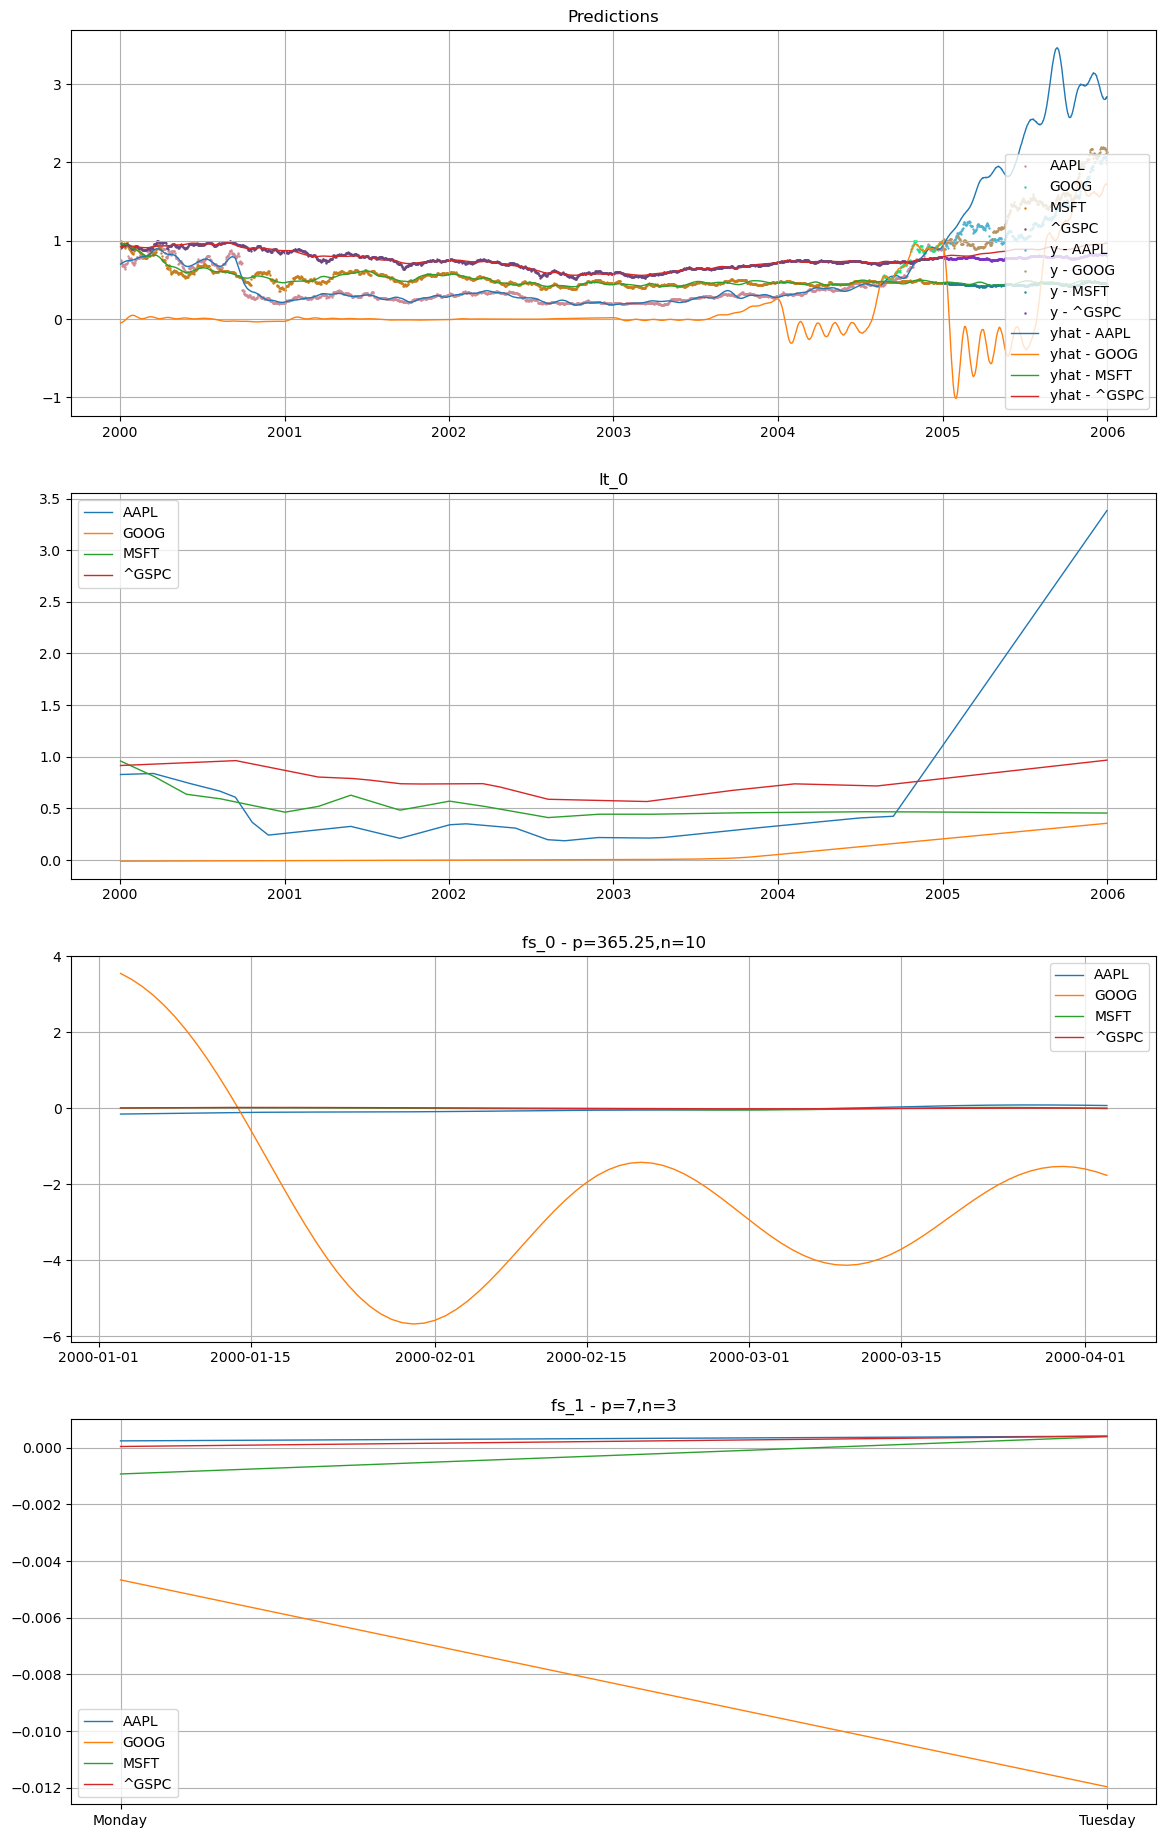

In [971]:
model.plot(yhat, y_true=test_df, pool_cols="series")

In [799]:
group, n_groups, groups_ = get_group_definition(new_model_.data, "series", "partial")
new_model_.data[group == 1]

,y,ds,series,t
0,0.641229,2008-03-19,small,0.000000
1,0.633742,2008-03-20,small,0.001372
2,0.631427,2008-03-21,small,0.002743
3,0.609728,2008-03-22,small,0.004115
4,0.623816,2008-03-23,small,0.005487
...,...,...,...,...
725,0.654035,2010-03-14,small,0.994513
726,0.668284,2010-03-15,small,0.995885
727,0.671617,2010-03-16,small,0.997257
728,0.670638,2010-03-17,small,0.998628


In [692]:
start = 100
window = 730
horizon = 365
# new_model = (LinearTrend(n_changepoints=1) + FourierSeasonality(7, 2)) * (LinearTrend(n_changepoints=5) * FourierSeasonality(365.25, 10))
new_model = LinearTrend()  + FourierSeasonality(365.25, 10)+ FourierSeasonality(7, 3)
# new_model = LinearTrend()
new_model.fit(df[start:start + window], use_prophet_initvals=False)
# preds = new_model.predict(horizon)
# preds

In [656]:
my_prophet = MyProphet()
my_prophet.fit(df[start:start + window])
my_prophet._predict_map(horizon)

,ds,t,yearly,weekly,trend,yhat
0,2008-03-19,0.000000,-0.412434,-0.034140,7.860868,7.414295
1,2008-03-20,0.001372,-0.410430,-0.085566,7.859444,7.363449
2,2008-03-21,0.002743,-0.410761,-0.075086,7.858020,7.372172
3,2008-03-22,0.004115,-0.413180,-0.264403,7.856596,7.179013
4,2008-03-23,0.005487,-0.417364,0.061939,7.855172,7.499746
...,...,...,...,...,...,...
1090,2011-03-14,1.495199,-0.472146,0.286729,9.418682,9.233265
1091,2011-03-15,1.496571,-0.456343,0.110527,9.421013,9.075198
1092,2011-03-16,1.497942,-0.442543,-0.034140,9.423345,8.946662
1093,2011-03-17,1.499314,-0.431037,-0.085566,9.425676,8.909074


In [877]:
new_model_.model

              lt_0 - slope ~ Normal(0, 5)
              lt_0 - delta ~ Laplace(0, 0.05)
          lt_0 - intercept ~ Normal(0, 5)
fs_0 - beta(p=365.25,n=10) ~ Normal(0, 10)
      fs_1 - beta(p=7,n=3) ~ Normal(0, 10)
                     sigma ~ HalfNormal(0, 0.5)
              lt_0 - trend ~ Deterministic(f(lt_0 - intercept, lt_0 - slope, lt_0 - delta))
                       obs ~ Normal(f(fs_1 - beta(p=7,n=3), fs_0 - beta(p=365.25,n=10), lt_0 - intercept, lt_0 - slope, lt_0 - delta), sigma)

In [879]:
new_model_.model.initial_point()

{'lt_0 - slope': array([0., 0., 0., 0.]),
 'lt_0 - delta': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'lt_0 - intercept': array([0., 0., 0., 0.]),
 'fs_0 - beta(p=365.25,n=10)': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0

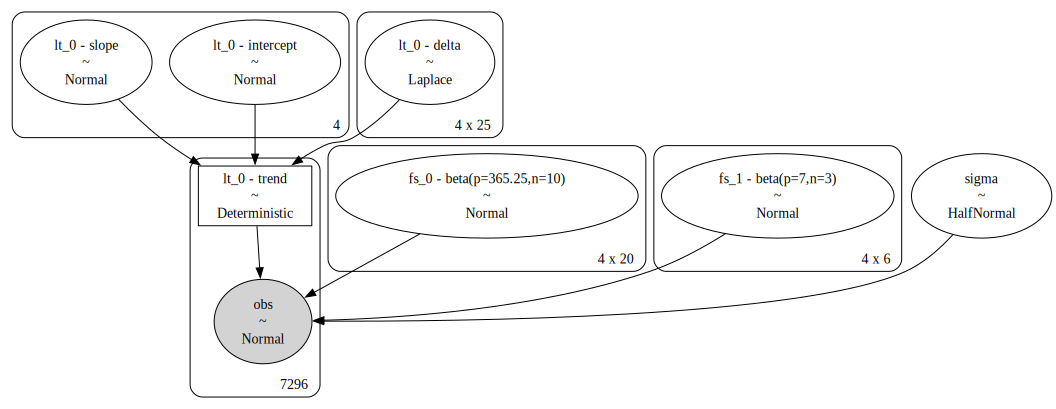

In [880]:
pm.model_to_graphviz(new_model_.model)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


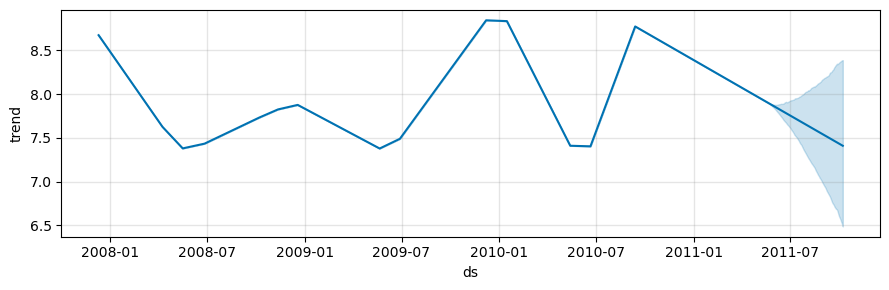

In [576]:
fig = model.plot_components(forecast)

<Axes: >

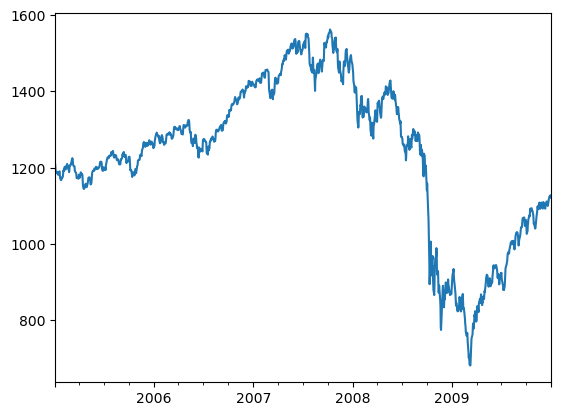

In [91]:
df["y"].plot()

In [39]:
df[df["ds"] > "2008-09-01"]

,ds,y
922,2008-09-02,1277.579956
923,2008-09-03,1274.979980
924,2008-09-04,1236.829956
925,2008-09-05,1242.310059
926,2008-09-08,1267.790039
...,...,...
1254,2009-12-24,1126.479980
1255,2009-12-28,1127.780029
1256,2009-12-29,1126.199951
1257,2009-12-30,1126.420044


<Axes: xlabel='Date'>

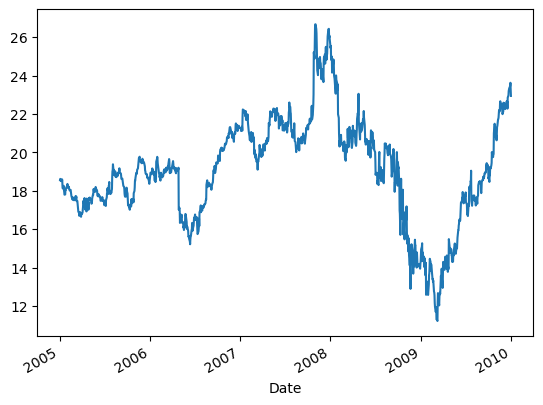

In [44]:
data["Adj Close"]["MSFT"].plot()

/tmp/ipykernel_47390/4007347958.py:193: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


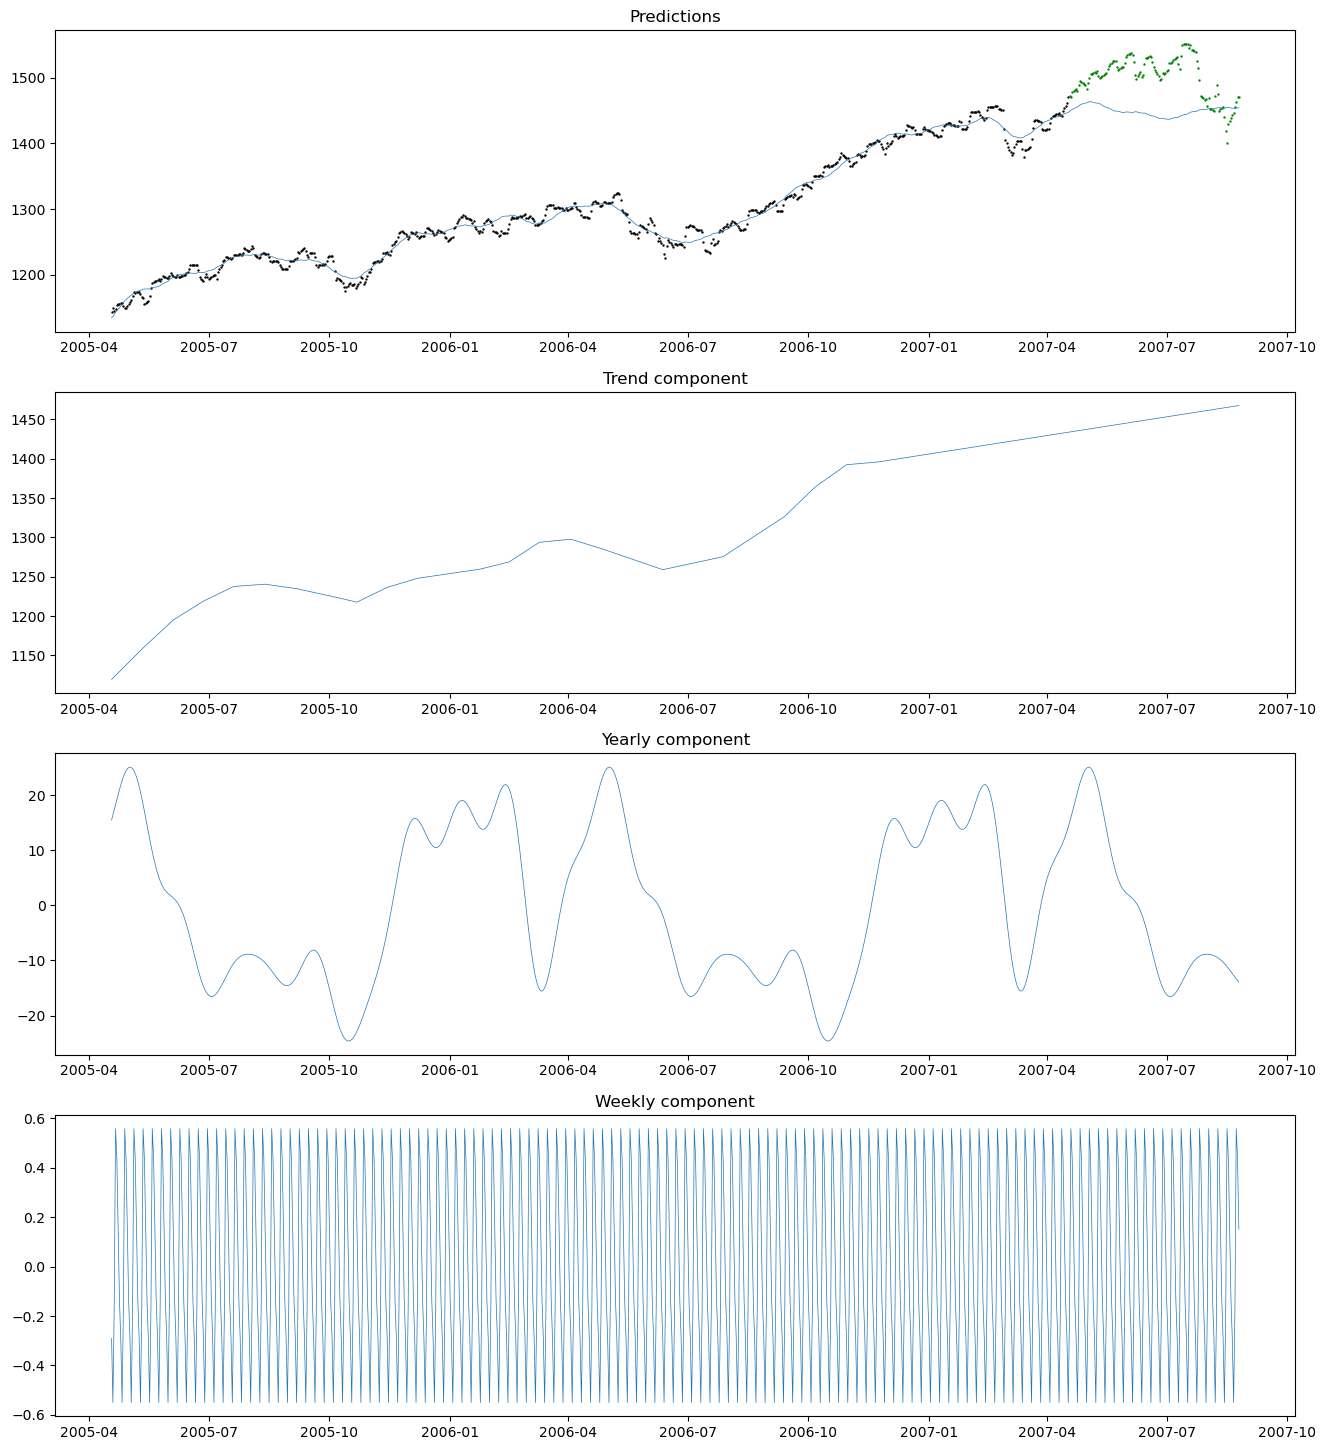

In [136]:
window = 730
horizon = 130
# start = randint(0, len(df) - window - horizon - 1)
start = 105
my_model = MyProphet()
my_model.fit(df[start:start + window])
preds = my_model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

In [144]:
new_model = LinearTrend() + FourierSeasonality(365.25, 10)
new_model.fit(df[start:start + window])

AttributeError: 'AdditiveTimeSeries' object has no attribute 'n_changepoints'

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


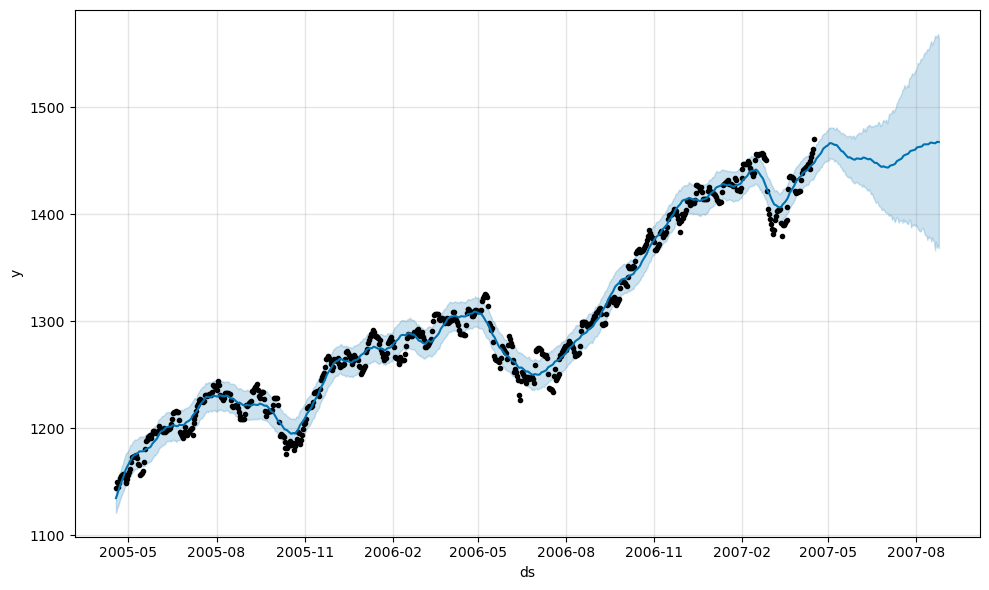

In [137]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

In [138]:
mean_absolute_percentage_error(preds["yhat"], forecast["yhat"])

0.0010129256080573092

In [139]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], preds["yhat"][window:])

0.03542767845554664

In [140]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], forecast["yhat"][window:])

0.033402113292251276

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

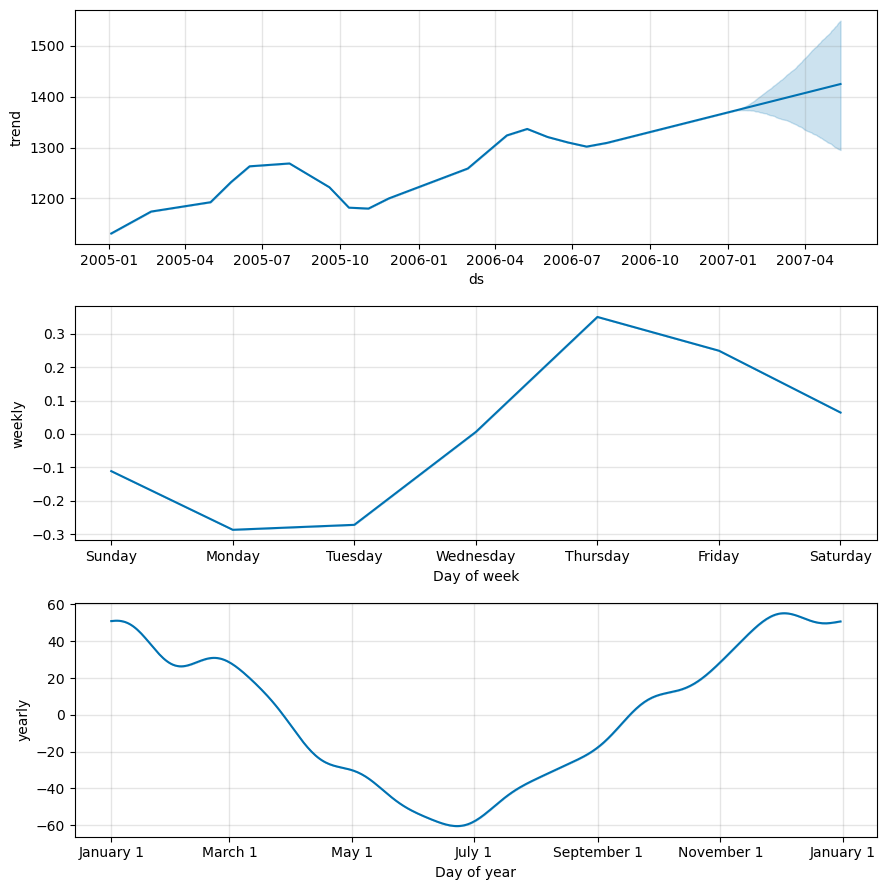

In [130]:
fig = model.plot_components(forecast)

In [104]:
df[start:start + window][["ds", "y"]]

,ds,y
576,2006-08-02,1275.572510
577,2006-08-03,1278.424988
578,2006-08-04,1281.589996
579,2006-08-05,1280.009176
580,2006-08-06,1278.428355
...,...,...
1301,2008-07-27,1249.952494
1302,2008-07-28,1246.647491
1303,2008-07-29,1249.789978
1304,2008-07-30,1274.407501
